In [1]:
import random
import time

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import torch

from src.model.activation import Relu, LeakyRelu, Linear, Sigmoid
from src.model.base import NeuralNetwork
from src.model.layer import Convolutional, Input3D, Input, FullyConnected, Flatten
from src.model.loss import CategoricalCrossEntropy
from src.model.metric import AccuracyOneHot
from src.model.optimizer import Adam, SGD

## Helper functions for displaying changes in loss and Accuracy with the change of epochs

In [2]:
def plot_loss(epoch, train_loss, test_loss, title):
    plt.figure(figsize=(10, 8))
    plt.plot(epoch, train_loss, color='r', label='Train')
    plt.plot(epoch, test_loss, color='g', label='Test')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_accuracy_score(epoch, train_metric, test_metric, title):
    plt.figure(figsize=(10, 8))
    plt.plot(epoch, train_metric, color='r', label='Train')
    plt.plot(epoch, test_metric, color='g', label='Test')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

## Function to display selected digit

In [3]:
def plot_digit(image, digit):
    image = torch.tensor(image).numpy().reshape(28, 28)
    plt.figure()
    plt.imshow(image, cmap="gray")
    plt.title(f"Predicted digit: {digit}")
    plt.axis("off")
    plt.show()

    return

## Function to display selected digit from cnn dataset 

In [4]:
def plot_digit_cnn(image, digit):
    image = torch.tensor(image).numpy()
    plt.figure()
    plt.title(f"Predicted digit: {digit}")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.show()

    return

## Helper function to get one-hot array for digit

In [5]:
def get_digit(onehot_array):
    for index, value in enumerate(onehot_array):
        if value == 1.0:
            return index
    return None

## Helper function to get digit by one-hot arrary

In [6]:
def get_onehot_digit(digit):
    output = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    return output[-digit:] + output[:-digit]

# 1. Classification on digits dataset using simple NN

## Function to get digits train/test data

In [7]:
def get_digits_data():

    train_dataset = []

    train = pd.read_csv("../data/digits/train.csv", header=0, nrows=10000)

    for index in train.index:
        input_values = [
            float(val) / 255.0 for val in train.loc[index].drop("label").values
        ]
        train_dataset.append(
            {
                "input": input_values,
                "output": get_onehot_digit(int(train.loc[index]["label"])),
            }
        )

    random.seed(3)
    random.shuffle(train_dataset)
    return train_dataset[:2000], train_dataset[2000:2500]

## Create simple NN model for classification on digits dataset and test

Epoch: 1/15, train loss: 2.0523, train Accuracy: 0.6575, test loss: 1.876, test Accuracy: 0.864, epoch time: 1.915s
Epoch: 2/15, train loss: 1.7872, train Accuracy: 0.8995, test loss: 1.7554, test Accuracy: 0.892, epoch time: 1.87s
Epoch: 3/15, train loss: 1.6915, train Accuracy: 0.943, test loss: 1.7157, test Accuracy: 0.918, epoch time: 1.881s
Epoch: 4/15, train loss: 1.6423, train Accuracy: 0.966, test loss: 1.6722, test Accuracy: 0.924, epoch time: 1.895s
Epoch: 5/15, train loss: 1.6085, train Accuracy: 0.9745, test loss: 1.6624, test Accuracy: 0.924, epoch time: 1.894s
Epoch: 6/15, train loss: 1.5844, train Accuracy: 0.989, test loss: 1.6407, test Accuracy: 0.926, epoch time: 1.941s
Epoch: 7/15, train loss: 1.5635, train Accuracy: 0.9915, test loss: 1.6268, test Accuracy: 0.932, epoch time: 1.912s
Epoch: 8/15, train loss: 1.5471, train Accuracy: 0.995, test loss: 1.6306, test Accuracy: 0.93, epoch time: 1.867s
Epoch: 9/15, train loss: 1.534, train Accuracy: 0.997, test loss: 1.613

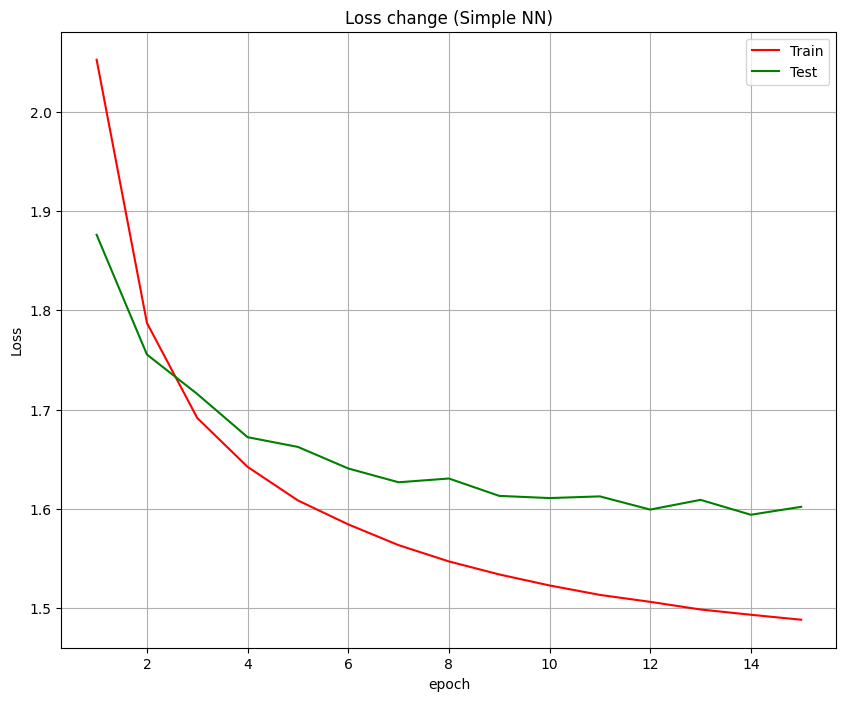

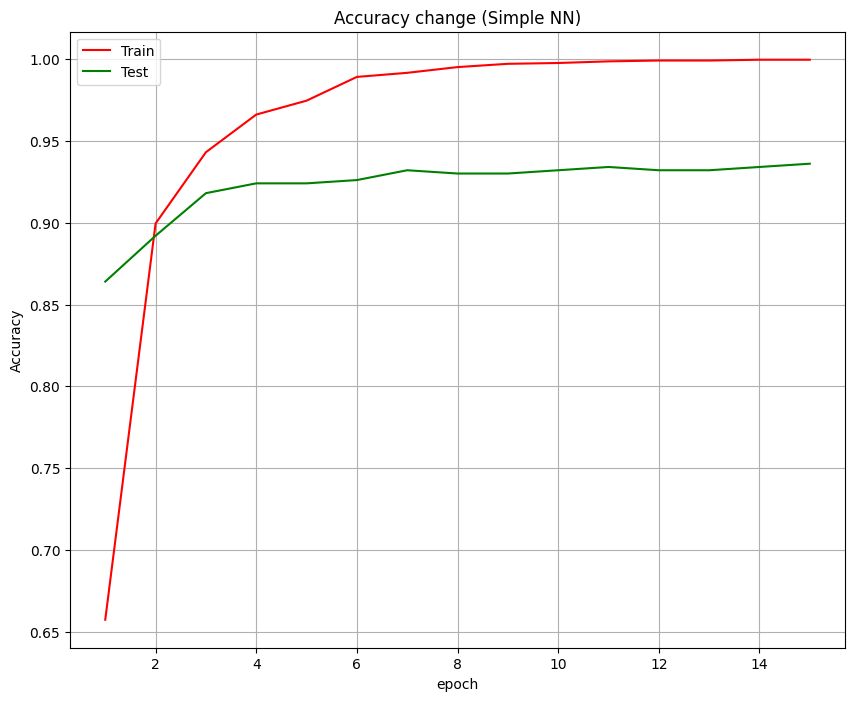

In [8]:
train_dataset, test_dataset = get_digits_data()

layers = [
    FullyConnected(512, LeakyRelu()),
    FullyConnected(128, LeakyRelu()),
    FullyConnected(32, LeakyRelu()),
    FullyConnected(10, Linear()),
]
nn = NeuralNetwork(
    Input(784),
    layers,
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossEntropy(),
    metric=AccuracyOneHot(),
    convert_prediction="argmax"
)

start_time = time.time()

epochs = 15
history = nn.fit(train_dataset, test_dataset, epochs=epochs, batch_size=8, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

prediction = nn.predict(test_dataset)

epoch = [epoch_data['epoch'] for epoch_data in history]
train_loss = [epoch_data['train_loss'] for epoch_data in history]
test_loss = [epoch_data['test_loss'] for epoch_data in history]
train_metric = [epoch_data['train_metric'] for epoch_data in history]
test_metric = [epoch_data['test_metric'] for epoch_data in history]

plot_loss(epoch, train_loss, test_loss, "Loss change (Simple NN)")
plot_accuracy_score(epoch, train_metric, test_metric, "Accuracy change (Simple NN)")

## First ten test digits with predicted values (Simple NN)

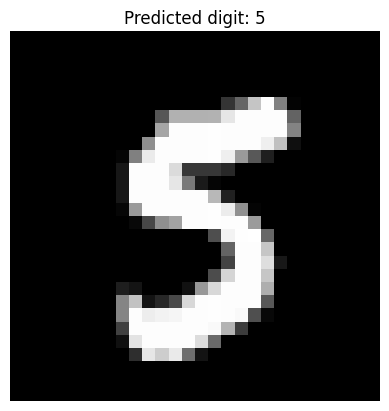

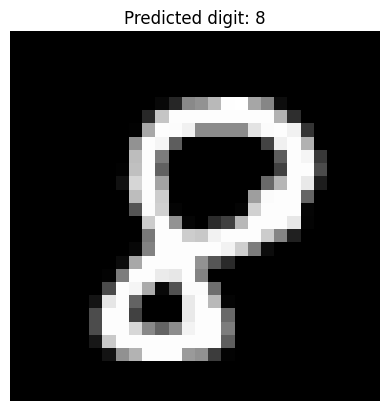

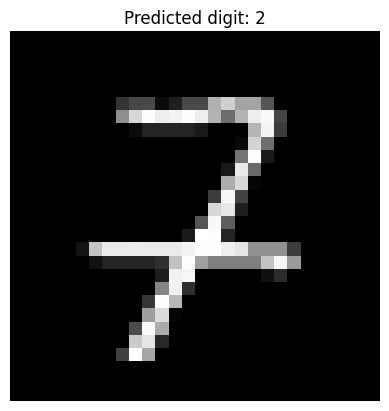

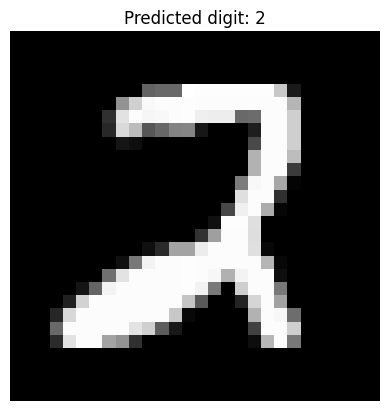

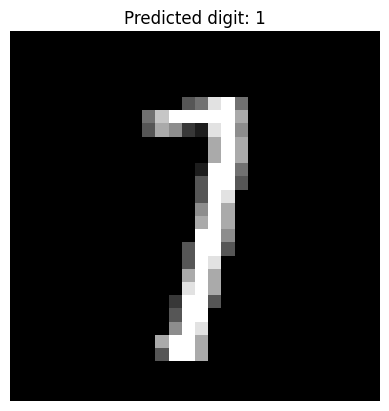

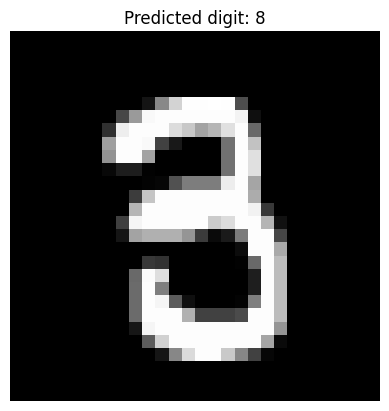

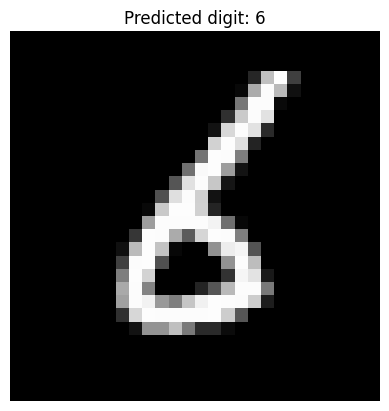

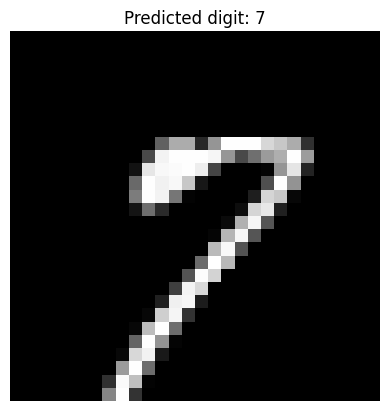

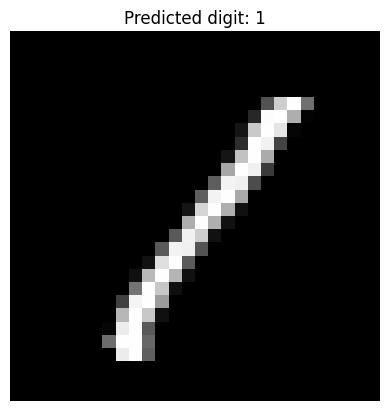

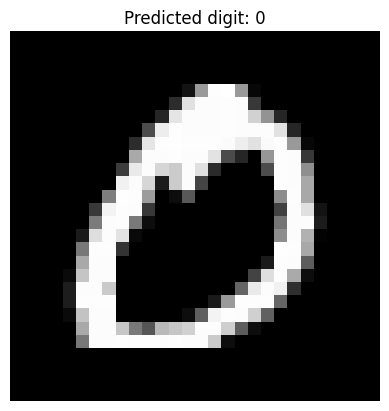

In [9]:
for index, predicted_digit in enumerate(prediction[:10]):
    plot_digit(test_dataset[index]['input'], get_digit(predicted_digit))

# 2. Classification on digits dataset using convolutional NN

## Function to get digits train/test data for CNN model

In [10]:
def get_digits_data_cnn():

    train_dataset = []

    train = pd.read_csv("../data/digits/train.csv", header=0, nrows=10000)

    for index in train.index:
        input_values = [
            float(val) / 255.0 for val in train.loc[index].drop("label").values
        ]
        train_dataset.append(
            {
                "input": [torch.tensor(input_values).reshape(28, 28).tolist()],
                "output": get_onehot_digit(int(train.loc[index]["label"])),
            }
        )
    
    random.seed(3)
    random.shuffle(train_dataset)
    return train_dataset[:2000], train_dataset[2000:2500]

## Create convolutional NN model for classification on digits dataset and test

In [ ]:
train_data, test_data = get_digits_data_cnn()

layers = [
    Convolutional(LeakyRelu(), filters_num=8, kernel_size=3, name="conv_1"),
    Convolutional(LeakyRelu(), filters_num=16, kernel_size=3, name="conv_2"),
    Convolutional(LeakyRelu(), filters_num=32, kernel_size=3, name="conv_3"),
    Flatten(name="flatten"),
    FullyConnected(128, LeakyRelu(), name="fc_1"),
    FullyConnected(10, Linear(), name="fc_2")
]
cnn = NeuralNetwork(
    Input3D((1, 28, 28)),
    layers,
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossEntropy(),
    metric=AccuracyOneHot(),
    convert_prediction='argmax',
    use_gpu=True
)

start_time = time.time()

epochs = 15
history = cnn.fit(train_data, test_data, epochs=epochs, batch_size=1, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

prediction = cnn.predict(test_data)

epoch = [epoch_data['epoch'] for epoch_data in history]
train_loss = [epoch_data['train_loss'] for epoch_data in history]
test_loss = [epoch_data['test_loss'] for epoch_data in history]
train_metric = [epoch_data['train_metric'] for epoch_data in history]
test_metric = [epoch_data['test_metric'] for epoch_data in history]

plot_loss(epoch, train_loss, test_loss, "Loss change (CNN)")
plot_accuracy_score(epoch, train_metric, test_metric, "Accuracy change (CNN)")

Epoch: 1/15, train loss: 1.7695, train Accuracy: 0.828, test loss: 1.5826, test Accuracy: 0.944, epoch time: 6.242s
Epoch: 2/15, train loss: 1.5814, train Accuracy: 0.9625, test loss: 1.6906, test Accuracy: 0.952, epoch time: 6.064s
Epoch: 3/15, train loss: 1.534, train Accuracy: 0.9895, test loss: 1.608, test Accuracy: 0.96, epoch time: 6.061s
Epoch: 4/15, train loss: 1.5205, train Accuracy: 0.992, test loss: 1.5988, test Accuracy: 0.962, epoch time: 6.139s
Epoch: 5/15, train loss: 1.507, train Accuracy: 0.9975, test loss: 1.6168, test Accuracy: 0.962, epoch time: 6.121s
Epoch: 6/15, train loss: 1.4995, train Accuracy: 0.997, test loss: 1.585, test Accuracy: 0.966, epoch time: 6.1s
Epoch: 7/15, train loss: 1.4946, train Accuracy: 0.9985, test loss: 1.5586, test Accuracy: 0.96, epoch time: 6.078s
Epoch: 8/15, train loss: 1.4879, train Accuracy: 0.9985, test loss: 1.5419, test Accuracy: 0.964, epoch time: 6.096s
Epoch: 9/15, train loss: 1.4852, train Accuracy: 1.0, test loss: 1.5625, te

## First ten test digits with predicted values (CNN)

In [ ]:
for index, predicted_digit in enumerate(prediction[:10]):
    plot_digit_cnn(test_data[index]['input'][0], get_digit(predicted_digit))